In [4]:
import sys
from datetime import datetime
import csv
from sklearn.externals.six.moves.urllib.request import urlopen
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.collections import LineCollection
from sklearn import cluster, covariance, manifold
import networkx as nx
import statsmodels.api as sm
import matplotlib.cm as cm
from scipy.stats import pearsonr
from collections import defaultdict
sys.path.append('/Users/lingfeiw/Documents/code/python/')
from MHP import MHP
%matplotlib inline

# flush print
def flushPrint(d):
    sys.stdout.write('\r')
    sys.stdout.write(d)
    sys.stdout.flush()
    
    
def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height],axisbg=axisbg)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

def OLSRegressFit(x,y):
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant, beta = res.params
    r2 = res.rsquared
    return [constant, beta, r2]

# 1. Stock correlation network 

## 1.1 Download data

In [121]:
#start_date = datetime(2003, 1, 1).date()
#end_date = datetime(2008, 1, 1).date()

s_dic = {
    'TOT': 'Total',
    'XOM': 'Exxon',
    'CVX': 'Chevron',
    'COP': 'ConocoPhillips',
    'VLO': 'Valero Energy',
    'MSFT': 'Microsoft',
    'IBM': 'IBM',
    'TWX': 'Time Warner',
    'CMCSA': 'Comcast',
    'CVC': 'Cablevision',
    'YHOO': 'Yahoo',
    'DELL': 'Dell',
    'HPQ': 'HP',
    'AMZN': 'Amazon',
    'TM': 'Toyota',
    'CAJ': 'Canon',
    'SNE': 'Sony',
    'F': 'Ford',
    'HMC': 'Honda',
    'NAV': 'Navistar',
    'NOC': 'Northrop Grumman',
    'BA': 'Boeing',
    'KO': 'Coca Cola',
    'MMM': '3M',
    'MCD': 'McDonald\'s',
    'PEP': 'Pepsi',
    'K': 'Kellogg',
    'UN': 'Unilever',
    'MAR': 'Marriott',
    'PG': 'Procter Gamble',
    'CL': 'Colgate-Palmolive',
    'GE': 'General Electrics',
    'WFC': 'Wells Fargo',
    'JPM': 'JPMorgan Chase',
    'AIG': 'AIG',
    'AXP': 'American express',
    'BAC': 'Bank of America',
    'GS': 'Goldman Sachs',
    'AAPL': 'Apple',
    'SAP': 'SAP',
    'CSCO': 'Cisco',
    'TXN': 'Texas Instruments',
    'XRX': 'Xerox',
    'WMT': 'Wal-Mart',
    'HD': 'Home Depot',
    'GSK': 'GlaxoSmithKline',
    'PFE': 'Pfizer',
    'SNY': 'Sanofi-Aventis',
    'NVS': 'Novartis',
    'KMB': 'Kimberly-Clark',
    'R': 'Ryder',
    'GD': 'General Dynamics',
    'RTN': 'Raytheon',
    'CVS': 'CVS',
    'CAT': 'Caterpillar',
    'DD': 'DuPont de Nemours'}

# download price data
D = []
for s,n in sorted(s_dic.items()):
    flushPrint(s)
    url = ('https://raw.githubusercontent.com/scikit-learn/examples-data/master/financial-data/{}.csv')
    data = list(csv.DictReader(l.decode('utf8') for l in urlopen(url.format(s))))
    D.append({'close': [float(rec['close']) for rec in data],'open': [float(rec['open']) for rec in data]})

YHOO

## 1.2 Stock price correlation test

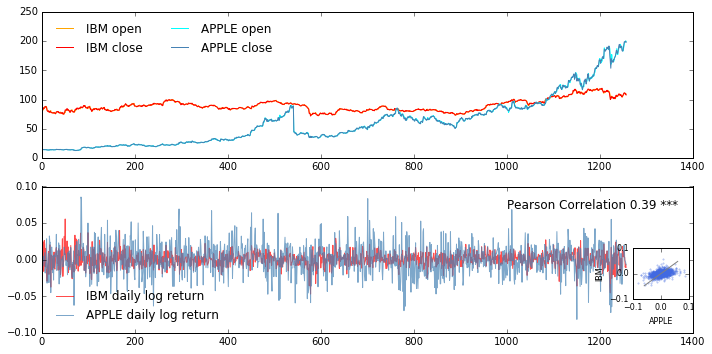

In [288]:

fig = plt.figure(figsize=(10, 5),facecolor='white')
ax = fig.add_subplot(211)
sn=sorted(s_dic.keys())
plt.plot(D[list(sn).index('IBM')]['open'],color='orange',label='IBM open')
plt.plot(D[list(sn).index('IBM')]['close'],color='red',label='IBM close')
plt.plot(D[list(sn).index('AAPL')]['open'],color='Cyan',label='APPLE open')
plt.plot(D[list(sn).index('AAPL')]['close'],color='SteelBlue',label='APPLE close')
plt.legend(loc=2,frameon=False,ncol=2)
#
ax = fig.add_subplot(212)
v0=np.log(np.array(D[list(sn).index('IBM')]['close'])/
          np.array(D[list(sn).index('IBM')]['open']))
v1=np.log(np.array(D[list(sn).index('AAPL')]['close'])/
          np.array(D[list(sn).index('AAPL')]['open']))
plt.plot(v0,color='r',label='IBM daily log return',alpha=0.7)
plt.plot(v1,color='SteelBlue',label='APPLE daily log return',alpha=0.7)
plt.legend(loc=3,frameon=False)
plt.text(1000,0.07,'Pearson Correlation 0.39 ***',size=12)
plt.ylim(-0.1,0.1)
subax = add_subplot_axes(ax,[0.98,0.1,0.1,0.4])
subax.plot(v1,v0,marker='.',markersize=3,linestyle='',color='RoyalBlue',alpha=0.3)
constant, beta, r2=OLSRegressFit(v0,v1)
xs=np.linspace(-0.06,0.06,10)
plt.plot(xs,constant+xs*beta,color='gray')
subax.tick_params(axis='both', which='major', labelsize=8)
subax.set_ylabel('IBM',size=8)
subax.set_xlabel('APPLE',size=8)
subax.set_xticks([-0.1,0,0.1])
subax.set_yticks([-0.1,0,0.1])
plt.tight_layout()

In [289]:
pearsonr(v0, v1)

(0.3886906681414472, 1.2275092526093317e-46)

## 1.3 Construct and visualize correlation network

In [592]:
# correlation matrix
close_prices = np.vstack([i['close'] for i in D])
open_prices = np.vstack([i['open'] for i in D])
#variation = close_prices - open_prices
logreturn = np.log(close_prices/open_prices)
#C=np.corrcoef(variation)
C=np.corrcoef(logreturn)

# matrix to network
g=nx.from_numpy_matrix(C)
symbols, names = np.array(sorted(s_dic.items())).T
h=nx.relabel_nodes(g,dict(zip(range(len(symbols)),symbols)))#rename 

# embed nodes by manifold learning
#X = variation.copy().T
X = logreturn.copy().T
X /= X.std(axis=0)
embedding = manifold.LocallyLinearEmbedding(
    n_components=2,eigen_solver='dense', n_neighbors=6).fit_transform(X.T).T
pos=dict(zip(symbols,embedding.T))

#group nodes by affinity propagation
edge_model = covariance.GraphLassoCV()
edge_model.fit(X)
groups={}
_, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = labels.max()
for i in range(n_labels + 1):
    groups[i] = names[labels == i]

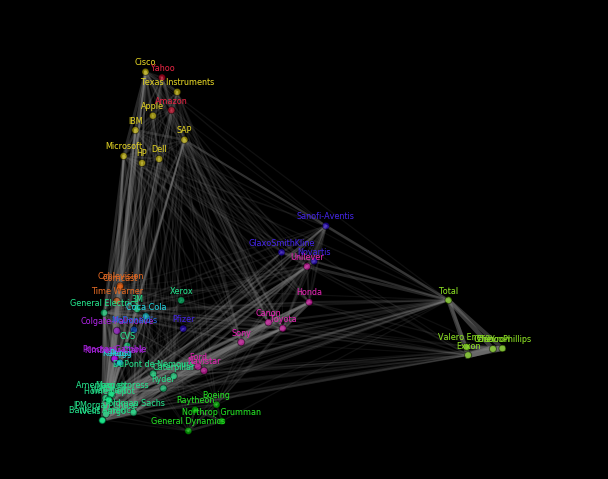

In [616]:
fig = plt.figure(figsize=(10, 8),facecolor='black')
ax = fig.add_subplot(111)
threshold=np.mean(C)
for i,j in h.edges():
    w=h[i][j]['weight']
    if w>=threshold:
        xi,yi=pos[i]
        xj,yj=pos[j]
        plt.plot([xi,xj],[yi,yj],color='grey',alpha=w**2,linewidth=w**2*10,zorder=1)
plt.scatter(embedding[0], embedding[1], s=50, facecolor=labels,edgecolor=None,
            cmap=plt.cm.get_cmap('gist_rainbow'),zorder=2,alpha=0.5)
for index, (name, label, (x, y)) in enumerate(zip(names, labels, embedding.T)):
    plt.text(x, y+.01, name, size=8,ha='center',fontsize=8,
             color=plt.cm.get_cmap('gist_rainbow')(label / float(n_labels)))
    plt.text(x, y+.01, name, size=8,ha='center',fontsize=8,color='gray',alpha=0.3)
ax.set_axis_bgcolor('black')
plt.savefig('/Users/lingfeiw/Documents/research/KatyPNAS/figures/hawkes/stockCorrelation.pdf',
           bbox_inches='tight', pad_inches=0)

# 2. Latent stock network inferred by Hawkes process

## 2.1 Univarate and multivariate Hawkes processes 

Max eigenvalue: 0.50000
Max eigenvalue: 0.10000


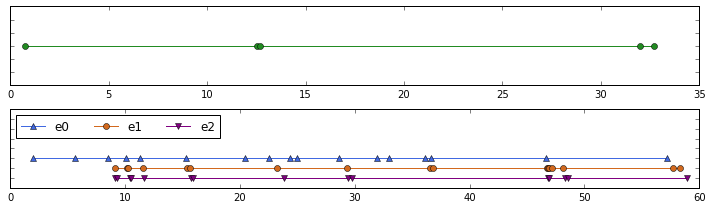

In [244]:
# generate data 
## dim = 1 
P1 = MHP(mu=np.array([0.1]),alpha=np.array([[0.5]]),omega=1.0)# or P = MHP() as default
D1 = P1.generate_seq(60)
# dim = 3
m = np.array([0.2, 0.0, 0.0])
a = np.array([[0.1, 0.0, 0.0], 
              [0.9, 0.0, 0.0],
              [0.0, 0.9, 0.0]])
w = 3.1
P3 = MHP(mu=m, alpha=a, omega=w)
D3 = P3.generate_seq(60)
d0=D3[D3[:,1]==0]
d1=D3[D3[:,1]==1]
d2=D3[D3[:,1]==2]

# plot 
fig = plt.figure(figsize=(10, 3),facecolor='white')
ax = fig.add_subplot(211)
plt.plot(D1[:,0],D1[:,1],marker='o',color='ForestGreen')
ax.set_yticklabels([])
#
ax = fig.add_subplot(212)
plt.plot(d0[:,0],d0[:,1],marker='^',color='RoyalBlue',label='e0')
plt.plot(d1[:,0],-d1[:,1],marker='o',color='Chocolate',label='e1')
plt.plot(d2[:,0],-d2[:,1],marker='v',color='purple',label='e2')
#ax = fig.add_subplot(212)
#plt.plot(data[:,0],'bo-')
plt.legend(loc=2,ncol=3,numpoints=1)
plt.xlim(0,60)
plt.ylim(-3,5)
ax.set_yticklabels([])
#
plt.tight_layout()

In [245]:
# estimating dim=3 data
mhat = np.random.uniform(0,1, size=3)
ahat = np.random.uniform(0,1, size=(3,3))
w = 3.
a_,m_=P3.EM(ahat, mhat, w)

After ITER 0 (old: -10000.000 new: -0.138)
 terms 18.2023, 24.0156, 24.9844
After ITER 10 (old: -0.138 new: -1.032)
 terms -18.6024, 17.0351, 31.9649
Reached stopping criterion. (Old: -1.032 New: -1.032)


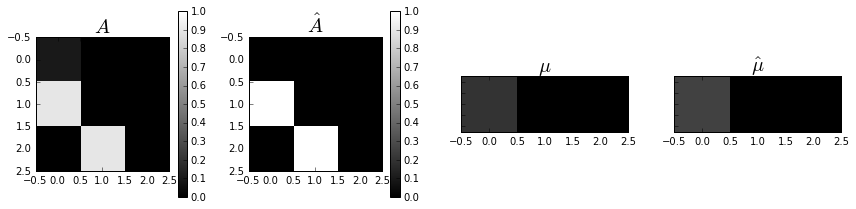

In [238]:
fig = plt.figure(figsize=(12, 3),facecolor='white')
ax = fig.add_subplot(141)
im=plt.imshow(a,cmap=plt.get_cmap('gray'), clim=(0,1),interpolation='nearest')
fig.colorbar(im)
plt.title(r'$A$',size=20)
ax = fig.add_subplot(142)
im=plt.imshow(a_,cmap=plt.get_cmap('gray'), clim=(0,1), interpolation='nearest')
plt.title(r'$\hat A$',size=20)
fig.colorbar(im)
ax = fig.add_subplot(143)
im=plt.imshow([m],cmap=plt.get_cmap('gray'), clim=(0,1), interpolation='nearest')
plt.title(r'$\mu$',size=20)
ax.set_yticklabels([])
ax = fig.add_subplot(144)
im=plt.imshow([m_],cmap=plt.get_cmap('gray'), clim=(0,1), interpolation='nearest')
plt.title(r'$\hat \mu$',size=20)
ax.set_yticklabels([])
plt.tight_layout()

In [247]:
np.round(a, decimals=2)

array([[ 0.1,  0. ,  0. ],
       [ 0.9,  0. ,  0. ],
       [ 0. ,  0.9,  0. ]])

In [246]:
np.round(a_, decimals=2) # w_10 >0, w_21 >0 : e0->e1, e1->e2

array([[ 0.  ,  0.  ,  0.  ],
       [ 0.83,  0.17,  0.  ],
       [ 0.  ,  0.88,  0.  ]])

In [248]:
np.round(m, decimals=2)

array([ 0.2,  0. ,  0. ])

In [249]:
np.round(m_, decimals=2) # mu(e0)=0.3

array([ 0.29,  0.  ,  0.  ])

## 2.2 Estimate two stock time series

In [5]:
def activate(variance,threshold):
    v=(variance>threshold).astype(int)
    w=np.where(v==1)
    return w[0]

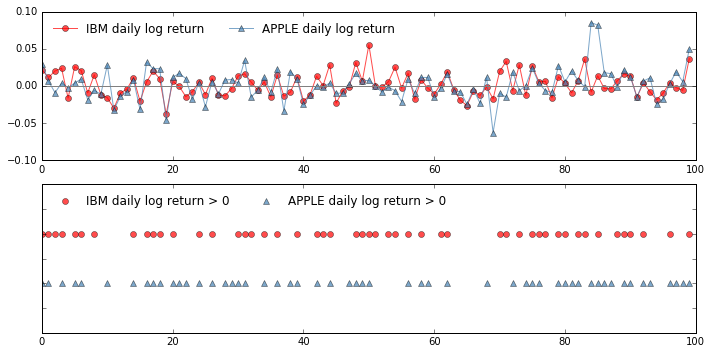

In [446]:
tmax=100
fig = plt.figure(figsize=(10, 5),facecolor='white')
ax = fig.add_subplot(211)
v0=np.log(np.array(D[list(sn).index('IBM')]['close'])/
          np.array(D[list(sn).index('IBM')]['open']))
v1=np.log(np.array(D[list(sn).index('AAPL')]['close'])/
          np.array(D[list(sn).index('AAPL')]['open']))
plt.plot(v0[:tmax],marker='o',color='r',label='IBM daily log return',alpha=0.7)
plt.plot(v1[:tmax],marker='^',color='SteelBlue',label='APPLE daily log return',alpha=0.7)
plt.plot([0,tmax],[0,0],color='gray')
plt.ylim(-0.1,0.1)
plt.legend(loc=2,numpoints=1,frameon=False,ncol=2)
ax = fig.add_subplot(212)
w0=activate(v0,0)
w1=activate(v1,0)
plt.plot(w0[w0<tmax],np.ones(len(w0[w0<tmax])),marker='o',linestyle='',
        color='r',label='IBM daily log return > 0',alpha=0.7)
plt.plot(w1[w1<tmax],np.ones(len(w1[w1<tmax]))-1,marker='^',linestyle='',
        color='SteelBlue',label='APPLE daily log return > 0',alpha=0.7)
plt.legend(loc=2,numpoints=1,frameon=False,ncol=2)
plt.xlim(0,tmax)
plt.ylim(-1,2)
ax.set_yticklabels([])
plt.tight_layout()

In [251]:
ndata=np.array(sorted(zip(w0,[0]*len(w0))+zip(w1,[1]*len(w1))))
dim=2
mhat = np.random.uniform(0,1, size=dim)
ahat = np.random.uniform(0,1, size=(dim,dim))
w = 3
Ptest = MHP(mu=mhat, alpha=ahat, omega=w)
Ptest.data=ndata
a_test,m_test=Ptest.EM(ahat, mhat, w)

Max eigenvalue: 1.36895
(WARNING) Unstable.
After ITER 0 (old: -10000.000 new: -0.336)
 terms 49.5154, 821.0181, 489.9819
After ITER 10 (old: -0.336 new: -0.668)
 terms -448.2749, 883.3218, 427.6782
Reached stopping criterion. (Old: -0.668 New: -0.668)


In [252]:
np.round(a_test, decimals=2)# w_10 >0 : APPLE -> IBM

array([[ 0.  ,  0.  ],
       [ 0.63,  0.  ]])

In [254]:
np.round(m_test, decimals=2)# mu(IBM)=0.54, mu(apple)=0.17

array([ 0.54,  0.17])

## 2.3 Estimate all stock time series

In [255]:
# 
#activation=[activate(i) for i in variation]


In [8]:
logs = [activate(i,0) for i in logreturn] 
Ndata=[]
for n,w in enumerate(logs):
    w=w[w<tmax]
    Ndata+=zip(w,[n]*len(w))
Ndata=np.array(sorted(Ndata))

NameError: name 'logreturn' is not defined

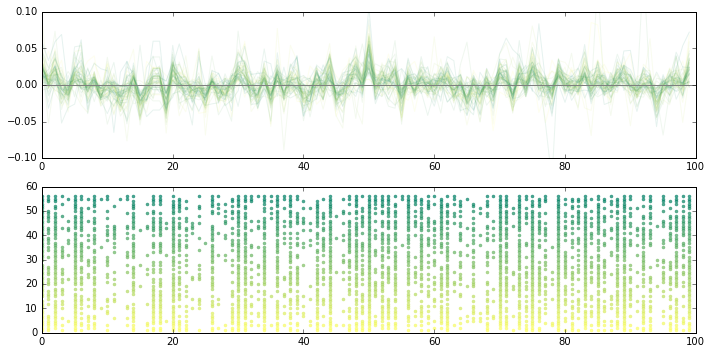

In [622]:
cmap = cm.get_cmap('summer_r',len(logs))
fig = plt.figure(figsize=(10, 5),facecolor='white')
ax = fig.add_subplot(211)
for n,w in enumerate(logreturn):
    plt.plot(w[:tmax],color=cmap(n),alpha=0.1)
plt.plot([0,tmax],[0,0],color='gray')
plt.ylim(-0.1,0.1)
ax = fig.add_subplot(212)
for n,w in enumerate(logs):
    w=w[w<tmax]
    plt.plot(w,np.ones(len(w))+n,marker='.',linestyle='',color=cmap(n),alpha=0.7)
#ax.set_yticklabels([])
plt.tight_layout()

In [5]:
dim=56
mhat = np.random.uniform(0,1, size=dim)
ahat = np.random.uniform(0,1, size=(dim,dim))
w = 3
Pall = MHP(mu=mhat, alpha=ahat, omega=w)
Pall.data=Ndata
a_all,m_all=Pall.EM(ahat, mhat, w)

Max eigenvalue: 27.85785
(WARNING) Unstable.


NameError: name 'Ndata' is not defined

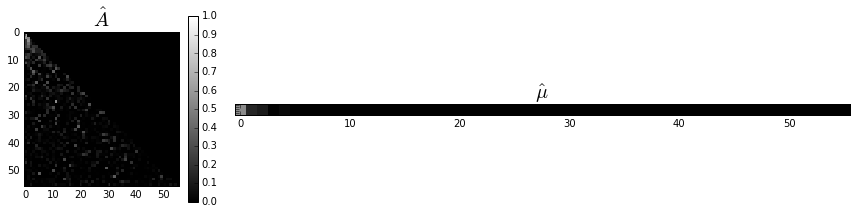

In [624]:
fig = plt.figure(figsize=(12, 3),facecolor='white')
ax = plt.subplot2grid((1, 4), (0, 0), colspan=1)
im=plt.imshow(a_all,cmap=plt.get_cmap('gray'), clim=(0,1),interpolation='nearest')
fig.colorbar(im)
plt.title(r'$\hat A$',size=20)
ax = plt.subplot2grid((1, 4), (0, 1), colspan=3)
im=plt.imshow([m_all],cmap=plt.get_cmap('gray'), clim=(0,1), interpolation='nearest')
plt.title(r'$\hat \mu$',size=20)
ax.set_yticklabels([])
plt.tight_layout()

In [296]:
np.round(a_all,decimals=2)

array([[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.67,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.54,  0.5 ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       ..., 
       [ 0.  ,  0.01,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.02, ...,  0.  ,  0.  ,  0.  ],
       [ 0.01,  0.  ,  0.04, ...,  0.01,  0.06,  0.  ]])

In [295]:
np.round(m_all,decimals=2)

array([ 0.55,  0.15,  0.11,  0.01,  0.04,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ])

In [16]:
G_all = nx.from_numpy_matrix(a_all.T, create_using=nx.DiGraph())
H_all=nx.relabel_nodes(G_all,dict(zip(range(len(symbols)),symbols)))#rename 

NameError: name 'a_all' is not defined

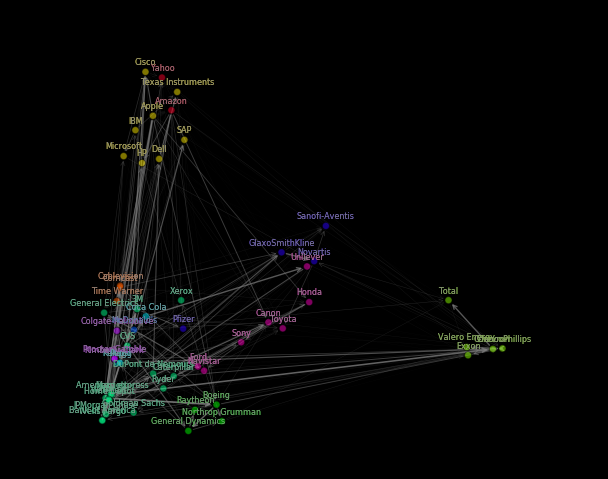

In [617]:
fig = plt.figure(figsize=(10, 8),facecolor='black')
ax = fig.add_subplot(111)
for i,j in H_all.edges():
    w=H_all[i][j]['weight']*2
    if w>0.001:
        xi,yi=pos[i]
        xj,yj=pos[j]
        ax.annotate("",xy=(xi,yi), xycoords='data',xytext=(xj,yj), textcoords='data',
                        arrowprops=dict(arrowstyle="<-", linewidth=w*2,color='0.5',
                                        alpha=w,shrinkA=5, shrinkB=5,
                        patchA=None,patchB=None,connectionstyle='Arc3',),zorder=1)
        
plt.scatter(embedding[0], embedding[1], s=50, facecolor=labels,edgecolor=None,
            cmap=plt.cm.get_cmap('gist_rainbow'),zorder=2,alpha=0.5)
for index, (name, label, (x, y)) in enumerate(zip(names, labels, embedding.T)):
    plt.text(x, y+.01, name, size=8,ha='center',fontsize=8,
             color=plt.cm.get_cmap('gist_rainbow')(label / float(n_labels)))
    plt.text(x, y+.01, name, size=8,ha='center',fontsize=8,color='gray')
ax.set_axis_bgcolor('black')
plt.savefig('/Users/lingfeiw/Documents/research/KatyPNAS/figures/hawkes/stockHawkes.pdf',
           bbox_inches='tight', pad_inches=0)

In [626]:
H = flowBalancing(H_all)
L = flowDistanceFromSource(H)
T = H.out_degree(weight='weight')
R = H.reverse()
L['source']=0
S=defaultdict(lambda:[])
for i in H.nodes():
    if i!='source':
        es=R[i]
        w,k=sorted([(es[j]['weight'],j) for j in es],reverse=True)[0]
        S[k].append(i)
treeDic=generateTree(S)
tree=treeDic['source']
d = buchheim(tree)
pos,edges=getThreePos(d)

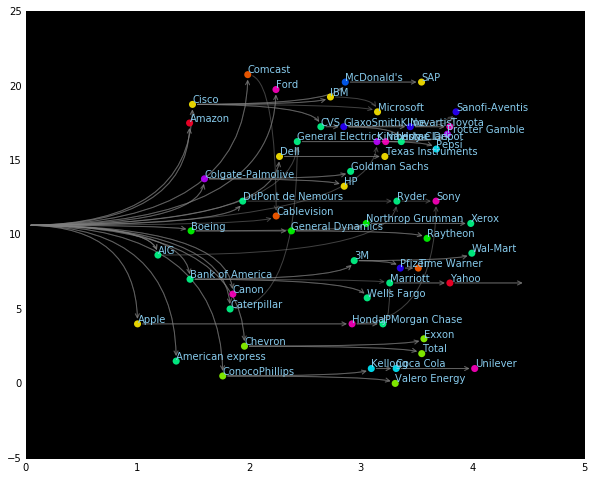

In [641]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
gp=dict(zip(symbols,labels))
for i in L:
    if i!='source' and i!='sink':
        x,y=pos[i]
        l=L[i]
        label=gp[i]
        plt.scatter(l,x,s=50,facecolor=plt.cm.get_cmap('gist_rainbow')(label / float(n_labels))
                    ,alpha=0.9,edgecolor='',zorder=2)
        plt.text(l,x,s_dic[i],rotation=0,ha='left',va='bottom',fontsize=10,
                     color='#88CCEE')
    else:
        x,y=pos[i]
        l=L[i]
        plt.scatter(x,l,s=50,facecolor='gray',alpha=0.9,edgecolor='',zorder=2)  
for i,j in edges:
    if i in L and j in L:
        x1,y1=pos[i]
        l1=L[i]
        x2,y2=pos[j]
        l2=L[j]
        ax.annotate("",xy=(l1,x1), xycoords='data',xytext=(l2,x2), textcoords='data',
                    arrowprops=dict(arrowstyle="<-", color="0.5",alpha=0.5,shrinkA=5, shrinkB=5,
                    patchA=None,patchB=None,connectionstyle='angle3,angleA=90,angleB=0',),zorder=1)
plt.xlim(0,5)
ax.set_axis_bgcolor('black')
plt.savefig('/Users/lingfeiw/Documents/research/KatyPNAS/figures/hawkes/stockHawkesFlow.pdf',
           bbox_inches='tight', pad_inches=0)

## 2.4 Skill time series

In [31]:
J={}
with open('/Users/lingfeiw/Documents/research/KatyPNAS/BG/skills-main-jobs-by-year.txt','rb') as f:
    for line in f:
        line=line.strip()
        skill=line.split('[')[0].strip().lower()
        vs=line.split('[')[1].split(']')[0].split(',')
        dic=dict((int(i.split(':')[0]),int(i.split(':')[1])) for i in vs)
        J[skill]=dic
        
JT=defaultdict(lambda:0)
for i in J:
    for year in J[i]:
        JT[year]+=J[i][year]
JN={}
for i in J:
    dic=dict((k,v/float(JT[k])) for k,v in J[i].items() if 2010<=k<=2016 and v!=0)
    if len(dic)==7:
        JN[i]=dic
        
SE=[]
with open('/Users/lingfeiw/Documents/research/KatyPNAS/BG/skills-list-DSDE-2010-2016.txt','rb') as f:
    for line in f:
        line=line.strip().split('\r')
        SE.append(line[0].lower())
len(SE)

2968

In [32]:
def activate(variance,threshold):
    v=(variance>threshold).astype(int)
    w=np.where(v==1)
    return w[0]

N=50
topSkills=zip(*sorted([(k,v) for k,v in J.items() if k in SE],
                      key=lambda x:-sum(x[1].values())))[0][:N]
DSDE=dict((k,v) for k,v in JN.items() if k in topSkills)
DSDE1={}
for s in DSDE:
    dic=DSDE[s]
    v=[dic[i] for i in range(2010,2017)]
    lr=np.log(np.array(v[1:])/np.array(v[:-1]))
    #t=sum(dic.values())
    #DSDE1[s]=dict((k,v/t) for k,v in dic.items())
    DSDE1[s]=lr
skill_logs = [activate(DSDE1[i],0) for i in DSDE1] 

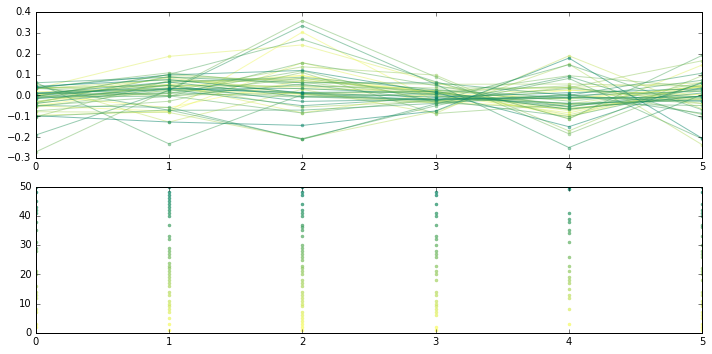

In [10]:
cmap = cm.get_cmap('summer_r',len(DSDE1))
fig = plt.figure(figsize=(10, 5),facecolor='white')
ax = fig.add_subplot(211)
for n,k in enumerate(DSDE1.keys()):
    lr=DSDE1[k]
    plt.plot(lr,color=cmap(n),alpha=0.5,marker='.')
ax = fig.add_subplot(212)
for n,w in enumerate(skill_logs):
    plt.plot(w,np.ones(len(w))+n,marker='.',linestyle='',color=cmap(n),alpha=0.7)
plt.tight_layout()

In [34]:
skill_data=[]
for n,w in enumerate(skill_logs):
    skill_data+=zip(w,[n]*len(w))
skill_data=np.array(sorted(skill_data))
len(skill_data)

167

In [37]:
M={}
for i in range(10):
    flushPrint(str(i))
    dim=50
    mhat = np.random.uniform(0,1, size=dim)
    ahat = np.random.uniform(0,1, size=(dim,dim))
    w = 3
    Pskill = MHP(mu=mhat, alpha=ahat, omega=w)
    Pskill.data=skill_data
    a_skill,m_skill=Pskill.EM(ahat, mhat, w)
    M[i]=a_skill

0Max eigenvalue: 25.20688
(WARNING) Unstable.
After ITER 0 (old: -10000.000 new: 1.963)
 terms 487.8220, 7.0208, 159.9792
After ITER 10 (old: 1.963 new: -0.031)
 terms 155.7140, 6.0741, 160.9259
After ITER 20 (old: -0.031 new: -0.007)
 terms 159.7460, 6.0140, 160.9860
Reached stopping criterion. (Old: -0.007 New: -0.004)
1Max eigenvalue: 24.78702
(WARNING) Unstable.
After ITER 0 (old: -10000.000 new: 1.933)
 terms 482.6989, 7.1942, 159.8058
After ITER 10 (old: 1.933 new: -0.028)
 terms 156.2563, 6.0132, 160.9868
After ITER 20 (old: -0.028 new: -0.007)
 terms 159.8694, 6.0083, 160.9917
Reached stopping criterion. (Old: -0.007 New: -0.004)
2Max eigenvalue: 25.00114
(WARNING) Unstable.
After ITER 0 (old: -10000.000 new: 1.946)
 terms 483.6028, 8.3945, 158.6055
After ITER 10 (old: 1.946 new: -0.034)
 terms 155.2335, 6.0474, 160.9526
After ITER 20 (old: -0.034 new: -0.009)
 terms 159.5590, 6.0116, 160.9884
Reached stopping criterion. (Old: -0.009 New: -0.005)
3Max eigenvalue: 24.97371
(WARN

In [56]:
dd=np.zeros((50,50))
for i in range(10):
    dd+=M[i]
dd=dd/10.0

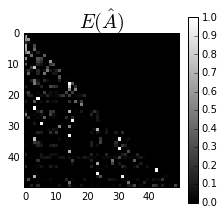

In [58]:
fig = plt.figure(figsize=(12, 3),facecolor='white')
ax = plt.subplot2grid((1, 4), (0, 0), colspan=1)
im=plt.imshow(a_skill,cmap=plt.get_cmap('gray'), clim=(0,1),interpolation='nearest')
fig.colorbar(im)
plt.title(r'$E(\hat A)$',size=20)
plt.tight_layout()

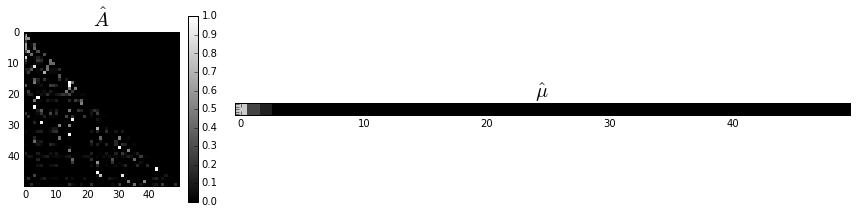

In [13]:
fig = plt.figure(figsize=(12, 3),facecolor='white')
ax = plt.subplot2grid((1, 4), (0, 0), colspan=1)
im=plt.imshow(a_skill,cmap=plt.get_cmap('gray'), clim=(0,1),interpolation='nearest')
fig.colorbar(im)
plt.title(r'$\hat A$',size=20)
ax = plt.subplot2grid((1, 4), (0, 1), colspan=3)
im=plt.imshow([m_skill],cmap=plt.get_cmap('gray'), clim=(0,1), interpolation='nearest')
plt.title(r'$\hat \mu$',size=20)
ax.set_yticklabels([])
plt.tight_layout()

In [67]:
np.round(dd,decimals=2)

array([[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.66,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.52,  0.56,  0.  , ...,  0.  ,  0.  ,  0.  ],
       ..., 
       [ 0.02,  0.27,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.17, ...,  0.  ,  0.12,  0.  ]])

In [17]:
np.round(m_skill,decimals=2)

array([ 0.8 ,  0.27,  0.13,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ])

In [66]:
G_all = nx.from_numpy_matrix(dd.T, create_using=nx.DiGraph())
H_all=nx.relabel_nodes(G_all,dict(zip(range(len(DSDE1)),DSDE1.keys())))#rename 

In [13]:
np.mean(a_skill),np.max(a_skill)

(0.023348736477146897, 0.99999999999975164)

In [14]:
from scipy import stats
100-stats.percentileofscore(a_skill.flatten(), 0.01)

13.0

In [75]:
#top three upstream
R_all = H_all.reverse()
R_ = nx.DiGraph()
for i in R_all.nodes():
    for a,b in sorted([(v['weight'],k) for k,v in R_all[i].items()],reverse=True)[:3]:
        R_.add_edge(b,i,weight=a) 

In [15]:
# embed nodes by manifold learning
#X = variation.copy().T
Xs = np.array(DSDE1.values()).T
Xs /= Xs.std(axis=0)
embeddings = manifold.LocallyLinearEmbedding(
    n_components=2,eigen_solver='dense', n_neighbors=6).fit_transform(Xs.T).T
poss=dict(zip(DSDE1.keys(),embeddings.T))

In [16]:
H_all['repair']['customer contact']

{'weight': 0.6631682362077651}

In [83]:
np.percentile(dd,(1-150/2500.0)*100)

0.10626377465753969

In [68]:
path='/Users/lingfeiw/Documents/research/KatyPNAS/figure8/influenceNetwork.txt'
with open(path,'w') as f:
    for i,j in H_all.edges():
        w=H_all[i][j]['weight']
        f.write(i+'\t'+j + '\t'+str(w)+'\n')

In [77]:
n=0
path='/Users/lingfeiw/Documents/research/KatyPNAS/figure8/influenceNetworkSkeletonTop3.txt'
with open(path,'w') as f:
    for i,j in R_.edges():
        w=R_[i][j]['weight']
        n+=1
        f.write(i+'\t'+j + '\t'+str(w)+'\n')
n

150

In [85]:
n=0
path='/Users/lingfeiw/Documents/research/KatyPNAS/figure8/influenceNetworkSkeletonTop150.txt'
with open(path,'w') as f:
    for i,j in H_all.edges():
        w=H_all[i][j]['weight']
        if w>0.106:
            n+=1
            f.write(i+'\t'+j + '\t'+str(w**2)+'\n')
n

151

In [17]:
len(H_all.edges())

2376

In [72]:
SHE=[]
for i,j in H_all.edges():
    w=H_all[i][j]['weight']
    if w>0.36:
        SHE.append([i,j,w])
len(SHE)

45

In [70]:
H_all['sql']['oracle']

{'weight': 0.36593601585980706}

[(0.5258849932686032, 'software development'),
 (0.4783695568779629, 'oracle'),
 (0.13259449433846038, 'inspection'),
 (0.038107649557998044, 'business development'),
 (0.01953334433230223, 'microsoft office'),
 (0.004037647795987186, 'project management'),
 (6.927000347563234e-23, 'repair'),
 (2.815936137944965e-33, 'computer skills'),
 (9.905537215257807e-35, 'multi-tasking'),
 (9.28357287326415e-37, 'sales'),
 (2.894477832080059e-38, 'microsoft word'),
 (1.143254795522409e-38, 'customer contact'),
 (7.866667506430272e-40, 'customer service'),
 (2.1919872912487266e-40, 'problem solving'),
 (1.1190886627995597e-40, 'typing'),
 (7.558117974776697e-41, 'data entry'),
 (1.2172451505809459e-41, 'english'),
 (1.0050247560328706e-41, 'merchandising'),
 (9.321017566615084e-42, 'mathematics'),
 (6.190246241028677e-42, 'time management'),
 (4.533573875723291e-42, 'store management'),
 (3.230486766437596e-42, 'scheduling'),
 (2.858084146339007e-42, 'building effective relationships'),
 (2.35136

In [20]:
n

325

In [42]:
soft=['communication skills','creativity','english','leadership','multi-tasking',
     'organizational skills','planning','problem solving','research','scheduling',
     'team work/ collaboration','project management','time management','writing','troubleshooting','teaching']

In [34]:
len(H_all.edges())

2376

In [46]:
path='/Users/lingfeiw/Documents/research/KatyPNAS/figure8/influenceNetworkNodePos.txt'
with open(path,'w') as f:
    for i in poss:
        x,y=poss[i]
        f.write(i+'\t'+str(x) + '\t'+str(y)+'\n')

In [1]:
H_all

NameError: name 'H_all' is not defined

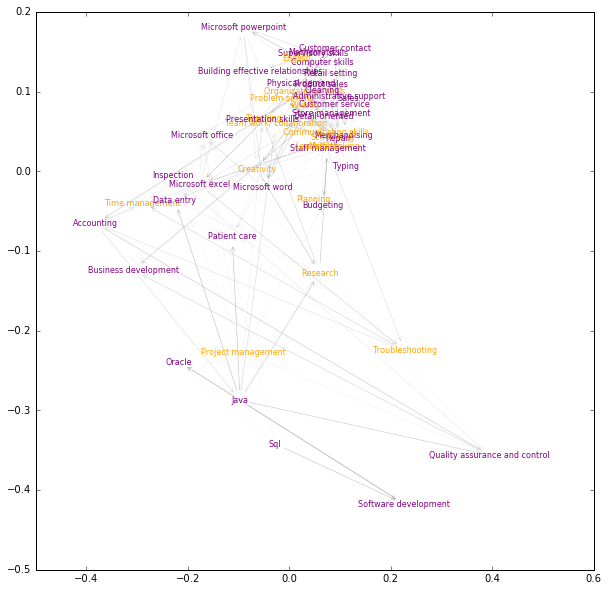

In [44]:
fig = plt.figure(figsize=(10, 10),facecolor='white')
ax = fig.add_subplot(111)
for i in poss:
    x,y=poss[i]
    if i in soft:
        #plt.scatter(x,y,s=50,facecolor='SteelBlue',alpha=0.3,edgecolor='')
        plt.text(x,y,i[0].upper()+i[1:],ha='center',va='center',fontsize=8,color='orange') 
    else:
        #plt.scatter(x,y,s=50,facecolor='green',alpha=0.5,edgecolor='')
        plt.text(x,y,i[0].upper()+i[1:],ha='center',va='center',fontsize=8,color='purple') 
for i,j in H_all.edges():
    w=H_all[i][j]['weight']
    if w>0.01:
        xi,yi=poss[i]
        xj,yj=poss[j]
        ax.annotate("",xy=(xi,yi), xycoords='data',xytext=(xj,yj), textcoords='data',
                        arrowprops=dict(arrowstyle="<-", linewidth=w,color=str(w),
                                        alpha=w,shrinkA=10, shrinkB=10,
                        patchA=None,patchB=None,connectionstyle='Arc3',),zorder=1)
plt.xlim(-.5,.6)
plt.ylim(-.5,.2)
#nx.draw(R_, pos=pos,with_labels=True,edge_color='gray',arrows=True)
#ax.set_axis_bgcolor('black')
plt.savefig('/Users/lingfeiw/Documents/research/KatyPNAS/figures/hawkes/skillHawkes.pdf',
           bbox_inches='tight', pad_inches=0)

In [67]:

H = flowBalancing(H_all)
L = flowDistanceFromSource(H)
T = H.out_degree(weight='weight')
R = H.reverse()
L['source']=0
S=defaultdict(lambda:[])
for i in H.nodes():
    if i!='source':
        es=R[i]
        w,k=sorted([(es[j]['weight'],j) for j in es],reverse=True)[0]
        S[k].append(i)
treeDic=generateTree(S)
tree=treeDic['source']
d = buchheim(tree)
pos,edges=getThreePos(d)

In [78]:
path='/Users/lingfeiw/Documents/research/KatyPNAS/figure8/influenceNetworkTreeLike.txt'
with open(path,'w') as f:
    for i,j in edges:
        f.write(i+'\t'+j + '\n')

In [79]:
path='/Users/lingfeiw/Documents/research/KatyPNAS/figure8/influenceNetworkTreeLikeNodePos.txt'
with open(path,'w') as f:
    for i in pos:
        x,y=pos[i]
        l=L[i]
        f.write(i+'\t'+str(l) + '\t'+str(x)+'\n')

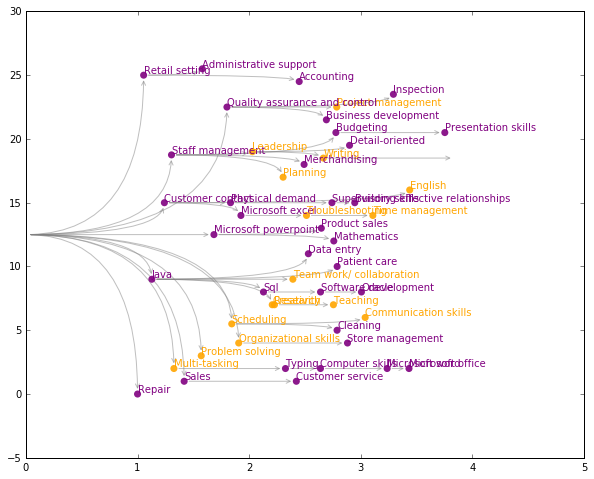

In [76]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
for i in L:
    if i!='source' and i!='sink':
        x,y=pos[i]
        l=L[i]
        #label=gp[i]
        if i in soft:
            plt.scatter(l,x,s=50,facecolor='orange',alpha=0.9,edgecolor='',zorder=2)
            plt.text(l,x,i[0].upper()+i[1:],rotation=0,ha='left',va='bottom',fontsize=10,
                         color='orange') 
        else:
            plt.scatter(l,x,s=50,facecolor='purple',alpha=0.9,edgecolor='',zorder=2)
            plt.text(l,x,i[0].upper()+i[1:],rotation=0,ha='left',va='bottom',fontsize=10,
                         color='purple')
    else:
        x,y=pos[i]
        l=L[i]
        plt.scatter(x,l,s=50,facecolor='gray',alpha=0.9,edgecolor='',zorder=2)  
for i,j in edges:
    if i in L and j in L:
        x1,y1=pos[i]
        l1=L[i]
        x2,y2=pos[j]
        l2=L[j]
        ax.annotate("",xy=(l1,x1), xycoords='data',xytext=(l2,x2), textcoords='data',
                    arrowprops=dict(arrowstyle="<-", color="0.5",alpha=0.5,shrinkA=5, shrinkB=5,
                    patchA=None,patchB=None,connectionstyle='angle3,angleA=90,angleB=0',),zorder=1)
plt.xlim(0,5)
#ax.set_axis_bgcolor('black')
#plt.savefig('/Users/lingfeiw/Documents/research/KatyPNAS/figures/hawkes/skillHawkesFlow.pdf',
#           bbox_inches='tight', pad_inches=0)
plt.savefig('/Users/lingfeiw/Documents/research/KatyPNAS/figures/hawkes/skillHawkesFlow.svg',
           bbox_inches='tight', pad_inches=0)

In [65]:
def flowDistanceFromSource(G): #input a balanced nx graph
    R = G.reverse()
    mapping = {'source':'sink','sink':'source'} 
    H = nx.relabel_nodes(R,mapping)
    #---------initialize flow distance dict------
    L = dict((i,1) for i in G.nodes())
    #---------prepare weighted out-degree dict------
    T = G.out_degree(weight='weight')
    #---------iterate until converge------------
    ls = np.array(L.values())
    delta = len(L)*0.01 + 1
    k=0
    while delta > len(L)*0.01:
        k+=1
        if k>20:
            break
        for i in L:
            l=1
            for m,n in H.edges(i):
                l+=L[n]*H[m][n].values()[0]/float(T[m])
            L[i]=l
        delta = sum(np.abs(np.array(L.values()) - ls))
        ls = np.array(L.values())
    #---------clean the result-------
    del L['sink']
    for i in L:
        L[i]-=1
    L['sink'] = L.pop('source')
    return L

def flowBalancing(G):
    RG = G.reverse()
    E=defaultdict(lambda:0)
    for x,y in G.edges():
        E[(x,y)]+=G[x][y]['weight']
    def nodeBalancing(node):
        outw=0
        for i in G.edges(node):
            outw+=G[i[0]][i[1]].values()[0]
        inw=0
        for i in RG.edges(node):
            inw+=RG[i[0]][i[1]].values()[0]
        deltaflow=inw-outw
        if deltaflow > 0:
            E[(node,'sink')]+=deltaflow
            #H.add_edge(node, "sink",weight=deltaflow)
        elif deltaflow < 0:
            E[('source',node)]+=abs(deltaflow)
            #H.add_edge("source", node, weight=abs(deltaflow))
        else:
            pass
    for i in G.nodes():
        nodeBalancing(i)
    H = nx.DiGraph()
    for x,y in E:
        H.add_edge(x,y, weight=E[(x,y)])
    if ("source", "source") in H.edges():  H.remove_edge("source", "source")    
    if ("sink", "sink") in H.edges(): H.remove_edge("sink", "sink")
    return H

In [66]:
#Tree ploting functions
# from http://billmill.org/pymag-trees/

class Tree:
    def __init__(self, node="", *children):
        self.node = node
        self.width = len(node)
        if children: self.children = children
        else:        self.children = []
    def __str__(self): 
        return "%s" % (self.node)
    def __repr__(self):
        return "%s" % (self.node)
    def __getitem__(self, key):
        if isinstance(key, int) or isinstance(key, slice): 
            return self.children[key]
        if isinstance(key, str):
            for child in self.children:
                if child.node == key: return child
    def __iter__(self): return self.children.__iter__()
    def __len__(self): return len(self.children)
    def addChild(self,nodeName): self.children.append(nodeName)

class DrawTree(object):
    def __init__(self, tree, parent=None, depth=0, number=1):
        self.x = -1.
        self.y = depth
        self.tree = tree
        self.children = [DrawTree(c, self, depth+1, i+1) 
                         for i, c
                         in enumerate(tree.children)]
        self.parent = parent
        self.thread = None
        self.mod = 0
        self.ancestor = self
        self.change = self.shift = 0
        self._lmost_sibling = None
        #this is the number of the node in its group of siblings 1..n
        self.number = number

    def left(self): 
        return self.thread or len(self.children) and self.children[0]

    def right(self):
        return self.thread or len(self.children) and self.children[-1]

    def lbrother(self):
        n = None
        if self.parent:
            for node in self.parent.children:
                if node == self: return n
                else:            n = node
        return n

    def get_lmost_sibling(self):
        if not self._lmost_sibling and self.parent and self != \
        self.parent.children[0]:
            self._lmost_sibling = self.parent.children[0]
        return self._lmost_sibling
    lmost_sibling = property(get_lmost_sibling)

    def __str__(self): return "%s: x=%s mod=%s" % (self.tree, self.x, self.mod)
    def __repr__(self): return self.__str__()        

def buchheim(tree):
    dt = firstwalk(DrawTree(tree))
    min = second_walk(dt)
    if min < 0:
        third_walk(dt, -min)
    return dt

def third_walk(tree, n):
    tree.x += n
    for c in tree.children:
        third_walk(c, n)

def firstwalk(v, distance=1.):
    if len(v.children) == 0:
        if v.lmost_sibling:
            v.x = v.lbrother().x + distance
        else:
            v.x = 0.
    else:
        default_ancestor = v.children[0]
        for w in v.children:
            firstwalk(w)
            default_ancestor = apportion(w, default_ancestor, distance)
        #print "finished v =", v.tree, "children"
        execute_shifts(v)

        midpoint = (v.children[0].x + v.children[-1].x) / 2

        ell = v.children[0]
        arr = v.children[-1]
        w = v.lbrother()
        if w:
            v.x = w.x + distance
            v.mod = v.x - midpoint
        else:
            v.x = midpoint
    return v

def apportion(v, default_ancestor, distance):
    w = v.lbrother()
    if w is not None:
        #in buchheim notation:
        #i == inner; o == outer; r == right; l == left; r = +; l = -
        vir = vor = v
        vil = w
        vol = v.lmost_sibling
        sir = sor = v.mod
        sil = vil.mod
        sol = vol.mod
        while vil.right() and vir.left():
            vil = vil.right()
            vir = vir.left()
            vol = vol.left()
            vor = vor.right()
            vor.ancestor = v
            shift = (vil.x + sil) - (vir.x + sir) + distance
            if shift > 0:
                move_subtree(ancestor(vil, v, default_ancestor), v, shift)
                sir = sir + shift
                sor = sor + shift
            sil += vil.mod
            sir += vir.mod
            sol += vol.mod
            sor += vor.mod
        if vil.right() and not vor.right():
            vor.thread = vil.right()
            vor.mod += sil - sor
        else:
            if vir.left() and not vol.left():
                vol.thread = vir.left()
                vol.mod += sir - sol
            default_ancestor = v
    return default_ancestor

def move_subtree(wl, wr, shift):
    subtrees = wr.number - wl.number
    #print wl.tree, "is conflicted with", wr.tree, 'moving', subtrees, 'shift', shift
    #print wl, wr, wr.number, wl.number, shift, subtrees, shift/subtrees
    wr.change -= shift / subtrees
    wr.shift += shift
    wl.change += shift / subtrees
    wr.x += shift
    wr.mod += shift

def execute_shifts(v):
    shift = change = 0
    for w in v.children[::-1]:
        #print "shift:", w, shift, w.change
        w.x += shift
        w.mod += shift
        change += w.change
        shift += w.shift + change

def ancestor(vil, v, default_ancestor):
    #the relevant text is at the bottom of page 7 of
    #"Improving Walker's Algorithm to Run in Linear Time" by Buchheim et al, (2002)
    #http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.16.8757&rep=rep1&type=pdf
    if vil.ancestor in v.parent.children:
        return vil.ancestor
    else:
        return default_ancestor

def second_walk(v, m=0, depth=0, min=None):
    v.x += m
    v.y = depth

    if min is None or v.x < min:
        min = v.x

    for w in v.children:
        min = second_walk(w, m + v.mod, depth+1, min)

    return min

def generateTree(edgeDic):
    allNodes={}
    for k,v in edgeDic.items():
        if k in allNodes:
            n=allNodes[k]
        else:
            n=Tree(k,)
            allNodes[k]=n
        for s in v:
            if s in allNodes:
                cn=allNodes[s]
            else:
                cn=Tree(s,)
                allNodes[s]=cn
            allNodes[k].addChild(cn)
    return allNodes

def getThreePos(root,pos={},edges=[]):
    pos[str(root.tree)]=[root.x,root.y]
    if root.children:
        for child in root.children:
            edges.append([str(root.tree),str(child.tree)])
            getThreePos(child,pos,edges)
    return pos,edges

In [63]:
def flowDistanceFromSource(G): #input a balanced nx graph
    R = G.reverse()
    mapping = {'source':'sink','sink':'source'} 
    H = nx.relabel_nodes(R,mapping)
    #---------initialize flow distance dict------
    L = dict((i,1) for i in G.nodes())
    #---------prepare weighted out-degree dict------
    T = G.out_degree(weight='weight')
    #---------iterate until converge------------
    ls = np.array(L.values())
    delta = len(L)*0.01 + 1
    k=0
    while delta > len(L)*0.01:
        k+=1
        if k>20:
            break
        for i in L:
            l=1
            for m,n in H.edges(i):
                l+=L[n]*H[m][n].values()[0]/float(T[m])
            L[i]=l
        delta = sum(np.abs(np.array(L.values()) - ls))
        ls = np.array(L.values())
    #---------clean the result-------
    del L['sink']
    for i in L:
        L[i]-=1
    L['sink'] = L.pop('source')
    return L

def flowBalancing(G):
    RG = G.reverse()
    E=defaultdict(lambda:0)
    for x,y in G.edges():
        E[(x,y)]+=G[x][y]['weight']
    def nodeBalancing(node):
        outw=0
        for i in G.edges(node):
            outw+=G[i[0]][i[1]].values()[0]
        inw=0
        for i in RG.edges(node):
            inw+=RG[i[0]][i[1]].values()[0]
        deltaflow=inw-outw
        if deltaflow > 0:
            E[(node,'sink')]+=deltaflow
            #H.add_edge(node, "sink",weight=deltaflow)
        elif deltaflow < 0:
            E[('source',node)]+=abs(deltaflow)
            #H.add_edge("source", node, weight=abs(deltaflow))
        else:
            pass
    for i in G.nodes():
        nodeBalancing(i)
    H = nx.DiGraph()
    for x,y in E:
        H.add_edge(x,y, weight=E[(x,y)])
    if ("source", "source") in H.edges():  H.remove_edge("source", "source")    
    if ("sink", "sink") in H.edges(): H.remove_edge("sink", "sink")
    return H